In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 150

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import everest

In [4]:
def sigma_clip(f, nsig=5):
    f = everest.math.SavGol(f)
    mu = np.median(f)
    std = np.sqrt(np.median((f - mu)**2))
    return np.abs(f - mu) < nsig*std

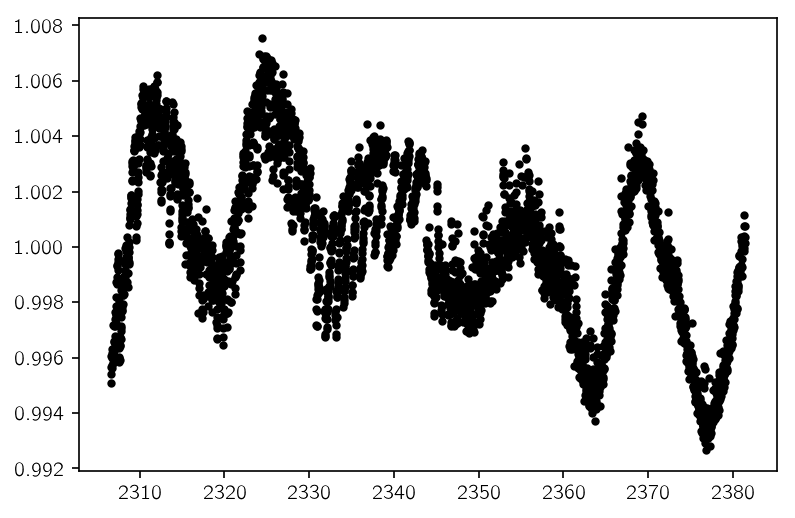

In [821]:
star = everest.Everest(211999343, quiet=True)
# star = everest.Everest(205924614, quiet=True)
# star = everest.Everest(206125618, quiet=True)   # Long period
# star = everest.Everest(212357477, quiet=True)
# star = everest.Everest(211383821, quiet=True)   # insanity
# star = everest.Everest(205050711, quiet=True)
# star = everest.Everest(201713348, quiet=True)     # Planet host
# star = everest.Everest(201324549, quiet=True)     # Rotation?
# star = everest.Everest(206105536, quiet=True)     # rrl; better
# star = everest.Everest(210771656, quiet=True)
# star = everest.Everest(205625849, quiet=True)     # rrl; not awesome
# star = everest.Everest(205117205, quiet=True)     # rotation
# star = everest.Everest(211836369, quiet=True)     # quiet
t = star.apply_mask(star.time)
F = star.apply_mask(star.fpix)
# fdet = star.apply_mask(star.flux)

# Find the outliers
fsap = np.sum(F, axis = 1)
# f = everest.math.SavGol(fsap)
# M = np.nanmedian(f)
# MAD = 1.4826 * np.nanmedian(np.abs(f - M))
# out = (f > M + 5 * MAD) | (f < M - 5 * MAD)
mask = sigma_clip(fsap)
# mask[:500] = False

# Apply the cut
t = np.array(t[mask])
fsap = np.array(fsap[mask])
F = np.array(F[mask, :])
# fdet = np.array(fdet[mask])

# Normalize
med = np.median(fsap)
fsap /= med
F /= med
# fdet /= med

# Plot
plt.plot(t, fsap, 'k.');

In [822]:
# B = F / fsap.reshape(-1, 1)
# w = np.linalg.solve(np.dot(B.T, B), np.dot(B.T, fsap-1.0))
# flux = fsap - np.dot(B, w)

# plt.plot(t, flux, ".")

for i in range(10):
    # Use first order PLD as a guess:
    B = F / fsap.reshape(-1, 1)
    w = np.linalg.solve(np.dot(B.T, B), np.dot(B.T, fsap-1.0))
    flux = fsap - np.dot(B, w)

    mask = sigma_clip(flux)
    t = np.array(t[mask])
    fsap = np.array(fsap[mask])
    F = np.array(F[mask, :])
    flux = flux[mask]
    print(len(t))

# plt.plot(t, flux[mask], ".")

3425
3417
3413
3412
3405
3398
3394
3394
3394
3394


14.5140451477


/Users/dforeman/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


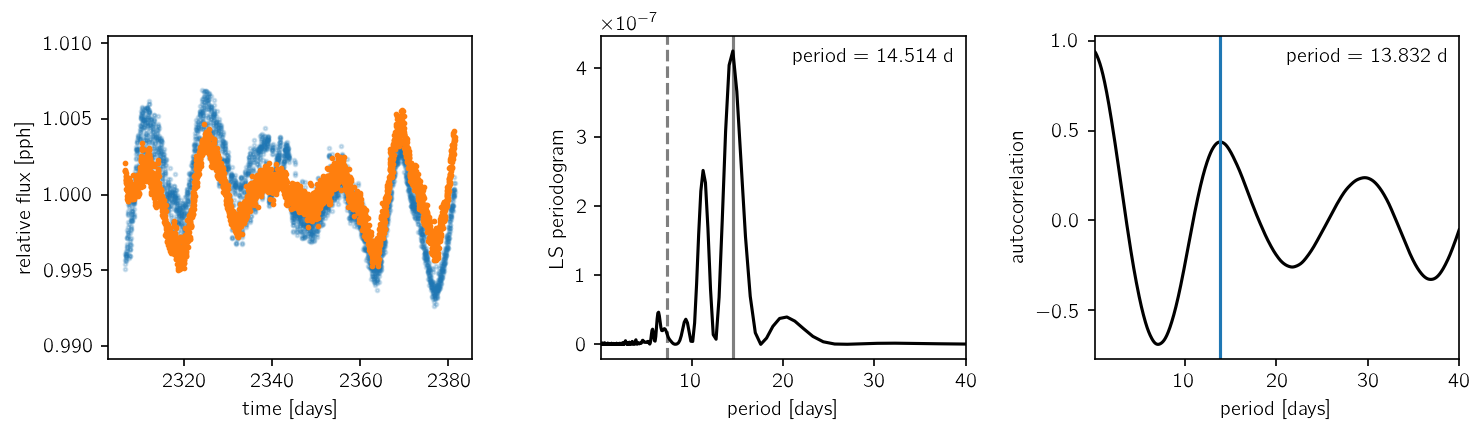

In [823]:
from astropy.stats import LombScargle
from emcee.autocorr import function_1d
from scipy.ndimage.filters import gaussian_filter

# First guess at the period
min_period, max_period = 0.1, 40.0

freq = np.linspace(1.0 / max_period, 1.0 / min_period, 5000)
model = LombScargle(t, flux)
power = model.power(freq, method="fast", normalization="psd")
power /= len(t)
power0 = np.array(power)

# Filter
freq0 = 1.0 / 10.0
filt = 1.0 / np.sqrt(1 + (freq0 / freq) ** (2*3))
power *= filt

period = 1.0 / freq[np.argmax(power)]
print(period)

# Acor
xx = np.arange(t.min(), t.max(), np.median(np.diff(t)))
tau = xx - xx.min()
acor = function_1d(np.interp(xx, t, flux))
acor = gaussian_filter(acor, 10)
peaks = (acor[1:-1] > acor[:-2]) & (acor[1:-1] > acor[2:])
max_acor = tau[1:-1][peaks][np.argsort(acor[1:-1][peaks])]
max_acor = max_acor[(max_acor > min_period) & (max_acor < max_period)]
if len(max_acor):
    max_acor = max_acor[-1]
else:
    max_acor = max_period

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].scatter(t, fsap, s=3, alpha=0.2)
axes[0].scatter(t, flux, s=3)
axes[0].set_ylabel("relative flux [pph]")
axes[0].set_xlabel("time [days]")

axes[1].plot(1.0 / freq, power, "k")
axes[1].axvline(period, color="k", alpha=0.5)
axes[1].axvline(0.5 * period, color="k", ls="dashed", alpha=0.5)
axes[1].set_xlabel("period [days]")
axes[1].set_ylabel("LS periodogram")
axes[1].annotate("period = {0:.3f} d".format(period), xy=(1, 1), xycoords="axes fraction",
                 ha="right", va="top", xytext=(-5, -5), textcoords="offset points")

axes[1].set_xlim(min_period, max_period)

axes[2].plot(tau, acor, "k")
axes[2].set_xlim(min_period, max_period)
axes[2].axvline(max_acor)
axes[2].set_xlabel("period [days]")
axes[2].set_ylabel("autocorrelation")
axes[2].annotate("period = {0:.3f} d".format(max_acor), xy=(1, 1), xycoords="axes fraction",
                 ha="right", va="top", xytext=(-5, -5), textcoords="offset points")

fig.set_tight_layout(True)

In [715]:
from itertools import combinations_with_replacement as multichoose

A = F / fsap.reshape(-1, 1)
A -= np.mean(A, axis=0)[None, :]
A = A[:, np.argsort(np.median(A, axis=0))[::-1]]
blocks = [A]
print(A.shape)
maxn = min(A.shape[1], 32)

for order in range(2, 4):
    A2 = np.product(list(multichoose(A[:, :maxn].T, order)), axis=1).T
    print(A2.shape)
    U, S, V = np.linalg.svd(A2 - np.mean(A2, axis=0), full_matrices=True)
    blocks.append(U[:, :order*maxn] - np.mean(U[:, :order*maxn], axis=0)[None, :])

(3458, 37)
(3458, 528)
(3458, 5984)


In [716]:
# nmid = len(t) // 2
# new_blocks = []
# for block in blocks:
#     b = np.array(block)
#     b[nmid:] = 0.0
#     new_blocks.append(b)
#     b = np.array(block)
#     b[:nmid] = 0.0
#     new_blocks.append(b)
# blocks = new_blocks

In [717]:
tt = 2*(t - t.min()) / (t.max() - t.min()) - 1
blocks.append(np.vander(tt, 4))

In [718]:
blocks.append(np.exp(-(t - t.min())[:, None]) / np.arange(1, 10)[None, :])

In [719]:
A = np.concatenate(blocks, axis=1)
block_sizes = np.array([block.shape[1] for block in blocks])
block_inds = np.append(0, np.cumsum(block_sizes))
block_inds = list(zip(block_inds[:-1], block_inds[1:]))

In [720]:
block_inds

[(0, 37), (37, 101), (101, 197), (197, 201), (201, 210)]

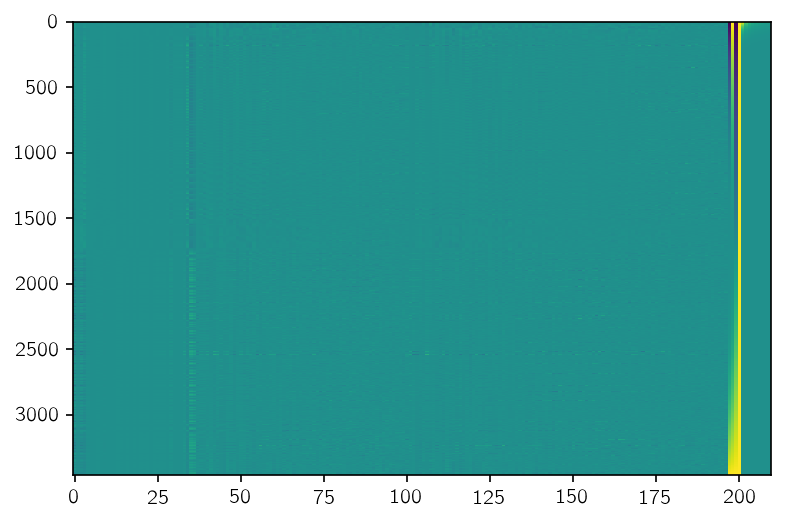

In [721]:
plt.imshow(A, aspect="auto")

In [722]:
import celerite
from celerite import terms

from rotate.rotation_term import RotationTerm, MixtureTerm, MixtureOfSHOsTerm

log_var = np.log(np.var(fsap))

kernel = terms.SHOTerm(
    log_S0=log_var,
#     log_Q=-0.5*np.log(2), 
    log_Q=-np.log(4.0), 
    log_omega0=np.log(2*np.pi/10.),
    bounds=dict(
        log_S0=(-20, 5),
        log_omega0=(np.log(2*np.pi/80.0), np.log(2*np.pi/2.0)),
    ),
)
kernel.freeze_parameter('log_Q')

kernel += MixtureTerm(
    log_a1=log_var,
    log_b1=-0.1,
    log_f1=-5.0,
    log_P=np.log(period),
    mix_par=-1.0,
    log_b2=-0.1,
    log_f2=-5.0,
    bounds=dict(
        log_a1=(-20.0, 10.0),
        log_b1=(-20.0, 5.0),
        log_f1=(-20.0, 5.0),
        log_P=(np.log(min_period), np.log(max_period)),
        mix_par=(-5.0, 5.0),
        log_b2=(-20.0, 5.0),
        log_f2=(-20.0, 5.0),
    ),
)

yerr = np.nanmedian(np.abs(np.diff(fsap)))
kernel += terms.JitterTerm(log_sigma=np.log(yerr))

gp = celerite.GP(kernel=kernel, mean=1.)
gp.compute(t)
initial_gp_params = gp.get_parameter_vector()

In [723]:
from scipy.linalg import cho_factor, cho_solve

def get_weights(log_lams):
    alpha = np.dot(A.T, gp.apply_inverse(fsap - gp.mean.value)[:, 0])
    ATKinvA = np.dot(A.T, gp.apply_inverse(A))
    S = np.array(ATKinvA)
    dids = np.diag_indices_from(S)
    for bid, (s, f) in enumerate(block_inds):
        S[(dids[0][s:f], dids[1][s:f])] += np.exp(-log_lams[bid])
    factor = cho_factor(S, overwrite_a=True)
    alpha -= np.dot(ATKinvA, cho_solve(factor, alpha))
    for bid, (s, f) in enumerate(block_inds):
        alpha[s:f] *= np.exp(log_lams[bid])
    return alpha

def get_pred(log_lams):
    w = get_weights(log_lams)
    return np.dot(A, w)

def nll(params):
    log_lams = params[:len(block_inds)]
    gp.set_parameter_vector(params[len(block_inds):])

    r = fsap - gp.mean.value
    
    try:
        alpha = gp.apply_inverse(r)[:, 0]
    except celerite.solver.LinAlgError:
        return np.inf
    
    value = np.dot(r, alpha)
    ATalpha = np.dot(A.T, alpha)
    
    try:
        S = np.dot(A.T, gp.apply_inverse(A))
    except celerite.solver.LinAlgError:
        return np.inf

    dids = np.diag_indices_from(S)
    for bid, (s, f) in enumerate(block_inds):
        S[(dids[0][s:f], dids[1][s:f])] += np.exp(-log_lams[bid])
    
    try:
        factor = cho_factor(S, overwrite_a=True)
        value -= np.dot(ATalpha, cho_solve(factor, ATalpha))
    except (np.linalg.LinAlgError, ValueError):
        return np.inf
   
    # Penalty terms
    log_det = 2*np.sum(np.log(np.diag(factor[0])))
    log_det += np.sum(log_lams * block_sizes)
    log_det += gp.solver.log_determinant()
   
    return 0.5 * (value + log_det)

In [724]:
from scipy.optimize import minimize

initial = np.log(1) * np.ones(len(block_inds))
# initial[-1] = np.log(20)
initial = np.append(initial, initial_gp_params)
bounds = [(-20, 10) for _ in block_inds] + gp.get_parameter_bounds()
soln = minimize(nll, initial, bounds=bounds)
soln

      fun: -26328.318866422702
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.2008968 , -0.3263267 , -0.24592737,  2.00525392,  0.52532414,
        2.96640792, -0.92913979,  0.05638867,  0.39290171,  2.57678039,
        3.37749952,  5.22595656,  4.78721631,  3.88863555,  1.48938852])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 912
      nit: 42
   status: 0
  success: True
        x: array([ -1.13075203, -13.83771203, -13.74115244,  -1.18048893,
        -0.2819165 , -13.00503469,  -0.43575997, -15.22310886,
        -0.7824242 ,  -6.72904072,   3.4507498 ,  -1.02164125,
        -0.65453166,  -6.90923295,  -8.24743303])

In [725]:
# Sigma clip
# mu = get_pred(log_lams)
# fdet = fsap - mu
# gppred = gp.predict(fdet, return_cov=False)
# resid = fdet - gppred

# plt.plot(resid)

In [726]:
initial

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        , -12.80692866,  -0.46470803, -12.80692866,
        -0.1       ,  -5.        ,   2.51489783,  -1.        ,
        -0.1       ,  -5.        ,  -7.73300605])

In [727]:
log_lams = soln.x[:len(block_inds)]
gp.set_parameter_vector(soln.x[len(block_inds):])
print(log_lams)

[ -1.13075203 -13.83771203 -13.74115244  -1.18048893  -0.2819165 ]


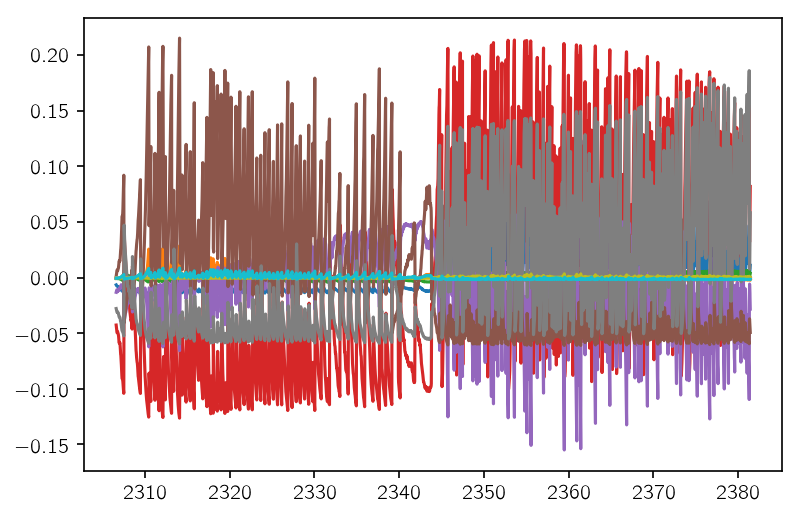

In [728]:
w = get_weights(log_lams)
inds = np.argsort(np.abs(w))[::-1][:10]
plt.plot(t, A[:, inds]);

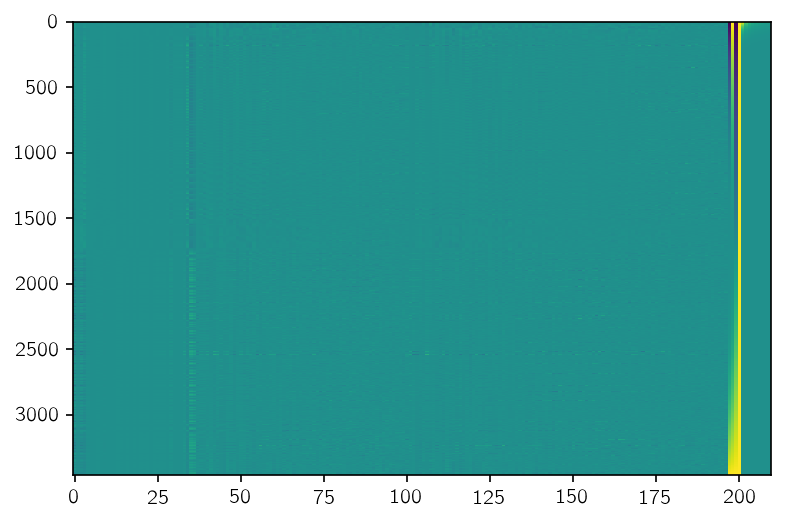

In [729]:
plt.imshow(A, aspect="auto")

[ 0.00484641  0.00403868  0.00346172  0.00302901  0.00269245]


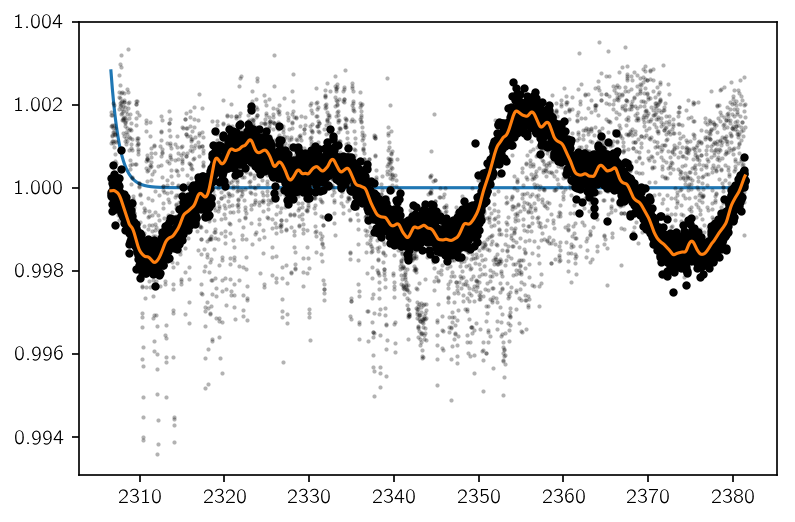

In [730]:
w = get_weights(log_lams)
print(w[-5:])
plt.plot(t, np.dot(A[:, -5:], w[-5:]) + 1)

mu = get_pred(log_lams)
fdet = fsap - mu
xx = np.linspace(t.min(), t.max(), len(t))
gppred, gpvar = gp.predict(fdet, xx, return_var=True)
gpstd = np.sqrt(gpvar)
plt.plot(t, fsap, 'k.', alpha=0.3, ms=4, mec="none");
plt.plot(t, fdet, 'k.');
# plt.plot(t, mu + 1);
plt.fill_between(xx, gppred - gpstd, gppred + gpstd, alpha=0.3)
plt.plot(xx, gppred)

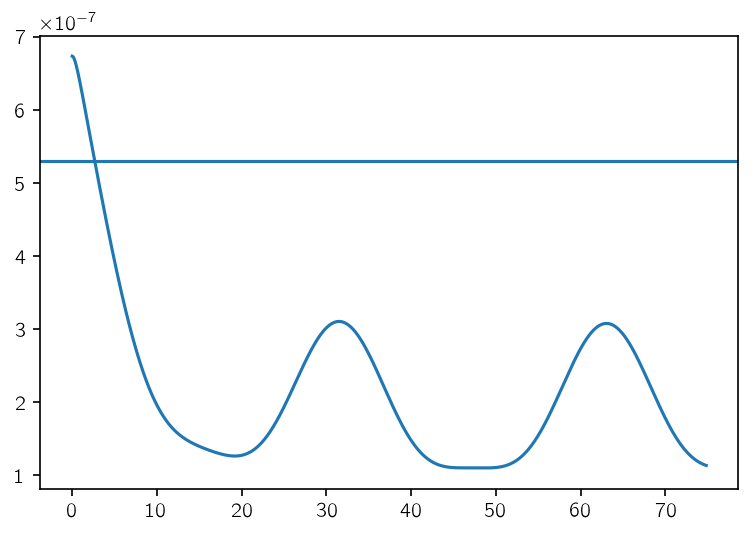

In [731]:
plt.plot(t - t.min(), gp.kernel.get_value(t - t.min()))
plt.axhline(np.var(flux))

In [732]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_S0', -13.005034691740171),
             ('kernel:terms[0]:log_omega0', -0.4357599678702499),
             ('kernel:terms[1]:log_a1', -15.223108858971672),
             ('kernel:terms[1]:log_b1', -0.78242419605168623),
             ('kernel:terms[1]:log_f1', -6.7290407153068337),
             ('kernel:terms[1]:log_P', 3.4507498047511658),
             ('kernel:terms[1]:mix_par', -1.0216412453095729),
             ('kernel:terms[1]:log_b2', -0.65453166025680021),
             ('kernel:terms[1]:log_f2', -6.9092329522797451),
             ('kernel:terms[2]:log_sigma', -8.2474330301531928)])

In [733]:
# np.exp(gp.get_parameter("kernel:terms[0]:log_S0"))

In [734]:
period = np.exp(gp.get_parameter("kernel:terms[1]:log_P"))
print(period)

31.5240203097


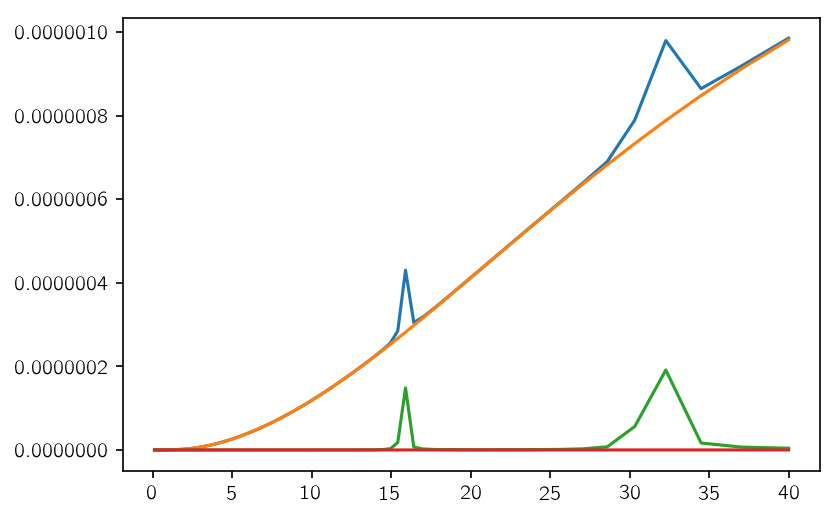

In [735]:
omega = 2 * np.pi * freq
plt.plot(1./freq, gp.kernel.get_psd(omega))
for term in gp.kernel.terms:
    plt.plot(1./freq, term.get_psd(omega))

In [736]:
period2 = 1. / freq[np.argmax(gp.kernel.get_psd(omega))]
print(period, period2, period - period2)

31.5240203097 40.0 -8.47597969035


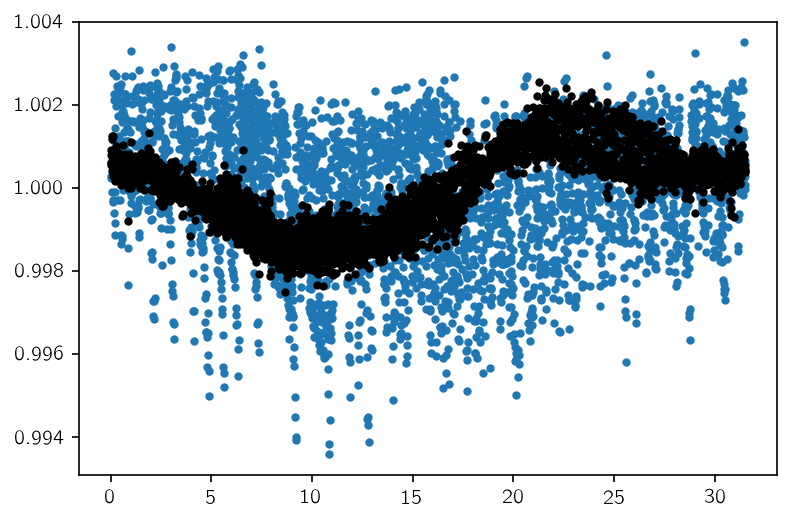

In [737]:
plt.plot(t % period, fsap, '.');
plt.plot(t % period, fdet, 'k.');

In [738]:
eps = 2e-3

gp.set_parameter("kernel:terms[1]:log_P", np.log(period+eps))
params = np.append(log_lams, gp.get_parameter_vector())
plus = nll(params)

gp.set_parameter("kernel:terms[1]:log_P", np.log(period-eps))
params = np.append(log_lams, gp.get_parameter_vector())
minus = nll(params)

gp.set_parameter("kernel:terms[1]:log_P", np.log(period))
params = np.append(log_lams, gp.get_parameter_vector())
base = nll(params)

nllpp = (plus - 2*base + minus) / eps**2
print(nllpp)

1.19208471006


In [739]:
1.0 / np.sqrt(np.abs(nllpp))

0.91589658807070085

In [740]:
plus, minus, base

(-26328.318723022345, -26328.31900505472, -26328.318866422702)

In [807]:
np.random.randint(-3, 3+1)

3